In [1]:
import math

import pandas as pd
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

import utils

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
stemmer = PorterStemmer()

In [3]:
tdf_g = pd.read_csv('speaker_grouped_trimmed.csv', index_col=0)

In [4]:
tdf_g

,date,speaker,text_enhanced
1696,1994-02-04,CHAIRMAN GREENSPAN.,"As you know, this is our organizational meetin..."
1697,1994-02-04,MR. BERNARD.,"Secretary and Economist, Donald Kohn; Deputy S..."
1698,1994-02-04,MR. BOEHNE.,"Normally in an economic expansion, development..."
1699,1994-02-04,MR. BROADDUS.,My report is going to be pretty bland after th...
1700,1994-02-04,MR. COYNE.,"Oh, believe me, you will get asked! I think i..."
...,...,...,...
6827,2017-12-13,MS. BRAINARD.,I don't think of this as a normative statement...
6828,2017-12-13,MS. GEORGE.,"Lorie, on exhibit 2, chart 12, would you expla..."
6829,2017-12-13,MS. LOGAN.,Thank you. I will begin on your second exhibi...
6830,2017-12-13,MS. MESTER.,"Thank you, Madam Chair. Reports received from..."


In [15]:
tdf_g['tokens'] = tdf_g['text_enhanced'].apply(lambda x : utils.process(x, stemmer=stemmer)) 

In [16]:
texts = tdf_g['tokens'].tolist()

In [17]:
dictionary = Dictionary(texts)

In [19]:
len(dictionary)

17519

In [18]:
unfiltered_corpus = [dictionary.doc2bow(text) for text in texts]

In [23]:
dictionary.doc2bow(['growth'])
dictionary[372]
dictionary.doc2bow(['product'])
dictionary[686]

'product'

In [24]:
count = 0

freqs = {}
doc_appears = {}

for text in texts:
    for token, freq in dictionary.doc2bow(text):
        if token in freqs:
            freqs[token] += freq
        else:
            freqs[token] = freq
        if token in doc_appears:
            doc_appears[token] += 1
        else:
            doc_appears[token] = 1
    count +=1

In [25]:
idf = {i: math.log(len(texts) / doc_appears[i]) for i in range(len(dictionary))}

In [26]:
tfidf_global = {i: idf[i] * (1 + math.log(freqs[i])) for i in range(len(dictionary))}

In [29]:
tfidf_global[686]

6.396551960972518

In [30]:
tfidf_vals = sorted([rank for rank in tfidf_global.values()], reverse=True)

In [33]:
tfidf_vals[15000]

8.509161019718974

In [ ]:
import random

i = 0
while i < 50:
    num = random.randint(0, len(dictionary) - 1)
    if tfidf_global[num] < tfidf_vals[13000]:
        print(dictionary[num])
        i += 1

In [ ]:
'1,200'.isnumeric()

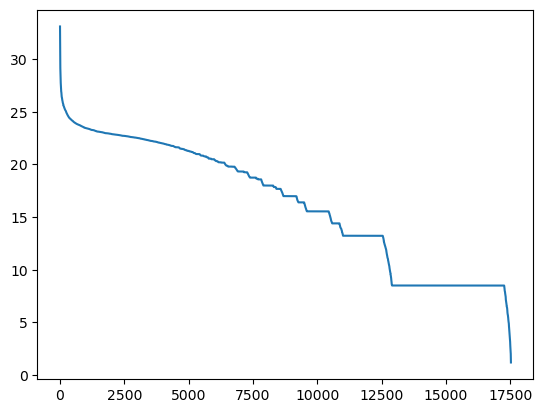

In [31]:
plt.plot(tfidf_vals)

In [34]:
tokens_to_keep = [i for i, tfidf in tfidf_global.items() if tfidf > tfidf_vals[11000]]
len(tokens_to_keep)

10992

In [35]:
dictionary.filter_tokens(good_ids=tokens_to_keep)
dictionary.compactify()
len(dictionary)

10992

In [36]:
'product' in dictionary

False

In [37]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [38]:
K = 45

In [39]:
ldamodel = LdaModel(corpus, num_topics=K, id2word=dictionary, passes=10, random_state=0, minimum_probability=0, eta=0.025, alpha=50/K)

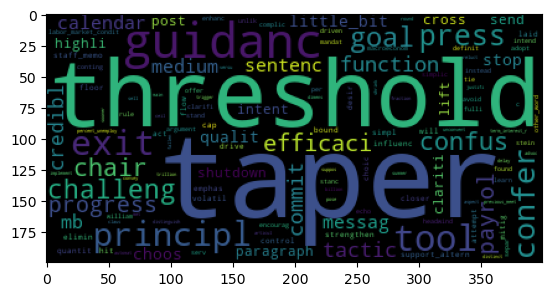

In [46]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(5, 200))))

In [ ]:
ldamodel.print_topics(num_topics=45, num_words=10)

In [ ]:
def get_all_topics(tokens):
    topic_probs = ldamodel[dictionary.doc2bow(tokens)]
    result = [0] * 45
    for topic, prob in topic_probs:
        result[topic] = prob
    return pd.Series(result)

In [ ]:
tdf_g[[f'tprob_{i}' for i in range(45)]] = tdf_g.tokens.apply(get_all_topics)

In [ ]:
tdf_g

In [ ]:
tdf_g['tokens']

EVENTUALLY FIX THIS TO ONLY INCLUDE WORDS NOT PRUNED BY TF-IDF

In [ ]:
tdf_g['len'] = tdf_g['tokens'].apply(len)

In [ ]:
tdf_g.to_csv('grouped_w_topics.csv')